In [1]:
import warnings
import numpy as np
import gc
import json
import h5py
import threading
import time
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, Input, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# training on 1080 Ti, you may want to adjust these for your own hardware
gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.65, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [2]:
def get_word_index():
    f = open('data/ams_word_index.json')
    data = json.load(f)
    f.close()
    return data


def load_vocab():
    with open('data/ams_word_index.json') as json_data:
        return json.load(json_data)

    
def load_glove():
    glove = {}
    with open('data/glove.model.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove


def build_embedding_layer(with_input=False, maxlen=480, vocab_dim=300, mask_zero=True):
    print("-- loading word embeddings, this may take a couple of minutes...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    print("-- embeddings ")
    if not with_input:
        embedding_layer = Embedding(
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False, weights=[embedding_weights])
        return embedding_layer
    else:
        # define inputs here
        input_1 = Input(shape=(maxlen,), dtype='int32')
        embedding_layer = Embedding(
            weights=[embedding_weights],
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False)(input_1)
        return (embedding_layer, input_1)


In [6]:
# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=480,
             n_classes=49, x_hf = None, y_hf = None, shuffle=True):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.dim), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.x_hf[ID]
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

batch_size = 128
# Parameters
data_hf = h5py.File("data/full_ams.hdf5", 'r')
generator_params = {
    'batch_size': batch_size,
    'n_classes': 50,
    'shuffle': False,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}
# Generators
training_generator = DataGenerator(**generator_params)
validation_generator = DataGenerator(mode="validation", **generator_params)


In [6]:
# It takes 10 minutes to recompute, memoizing here for the v5 50 class variant:
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)
class_weights = [
  0.2048110334858486, 1.3013211181655675, 5823.8158620689655, 
  5277.833125, 7.1379341532479605, 4444.491052631579, 
  64.83326679462571, 2.35259803033891, 649.5794615384615, 
  0.7418287154980059, 53.44641139240506, 4.702641309795623, 
  280.54926910299, 97.06359770114942, 0.48335678225132506, 
  893.6013756613756, 0.30742495067094794, 9.161413615405479, 
  1.8098013287612515, 0.7152746908351686, 521.2674691358025, 
  42222.665, 15353.696363636363, 1362.0214516129033, 
  12991.58923076923, 11.902090204369275, 21111.3325, 
  0.30661456290938666, 5117.8987878787875, 134.89669329073482, 
  0.15985652816716106, 4.142116544857017, 12.710013546056592, 
  47.3083081232493, 42222.665, 11.243636242593702, 
  18.71572030141844, 893.6013756613756, 6.951949452539722, 
  0.09931251242210093, 0.254639873472114, 7.750122063142437, 
  8.027122623574144, 0.33036140289106664, 0.8799917675317706, 
  272.40429032258066, 1289.241679389313, 30.55185600578871, 
  1796.7091489361703, 0.16395304994777288 ]

# 08.2018 (subformula lexemes)
# Analyzing the arxiv dataset seems to indicate 
#   a maxlen of 960 is needed to fit 99.2% of the data
#   a maxlen of 480 fits 96.03%, and a maxlen of 300 covers 90.0% of paragraphs
maxlen = 480
# Preparing word embeddings
embedding_layer = build_embedding_layer(maxlen=maxlen, mask_zero=False)

-- loading word embeddings, this may take a couple of minutes...
-- known dictionary items:  1000296
-- embeddings 


In [7]:
# BiLSTM Model Setup
n_classes = 50
layer_size = 128  # ~maxlen // 4

print("-- setting up model layout...")
use_dropout = True

model = Sequential()
model.add(embedding_layer)
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size // 2, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.1))

model.add(CuDNNLSTM(layer_size // 2))
if use_dropout:
    model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

# Print model summary
print(model.summary())

-- setting up model layout...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 480, 300)          300088800 
_________________________________________________________________
dropout_1 (Dropout)          (None, 480, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 480, 256)          440320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 480, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 480, 128)          164864    
_________________________________________________________

In [8]:
model_file = "confusion_bilstm%d_batch%d_cat%d_gpu" % (
    layer_size, batch_size, n_classes)

# Checkpoints: 1) save best model at epoch end, 2) stop early when metric stops improving
checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
                             monitor='val_weighted_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          restore_best_weights=True,
                          verbose=0, mode='auto')


In [9]:
# Perform training
print('-- training model...')
# TODO: How can we make this work with more workers? HDF5 is not thread-safe for reads...
# maybe use the unpacked .txt files and map them through the dictionary each time? Unsure... 
# On a single CPU worker: 2.5 hours per epoch for the full data, with the main BiLSTM model.
model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    workers = 1,
    use_multiprocessing=False,
    class_weight=class_weights,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, earlystop])

print("-- saving model to disk : %s " % model_file)
model.save(model_file+'_notebook.h5')

-- training model...
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
59375/59375 [==============================] - 9712s 164ms/step - loss: 1.0308 - weighted_sparse_categorical_accuracy: 0.6489 - val_loss: 0.9523 - val_weighted_sparse_categorical_accuracy: 0.6711

Epoch 00001: val_weighted_sparse_categorical_accuracy improved from -inf to 0.67106, saving model to confusion_bilstm128_batch128_cat50_gpu-checkpoint.h5
Epoch 2/50
59375/59375 [==============================] - 9723s 164ms/step - loss: 0.9222 - weighted_sparse_categorical_accuracy: 0.6795 - val_loss: 0.9239 - val_weighted_sparse_categorical_accuracy: 0.6789

Epoch 00002: val_weighted_sparse_categorical_accuracy improved from 0.67106 to 0.67891, saving model to confusion_bilstm128_batch128_cat50_gpu-checkpoint.h5
Epoch 3/50
59375/59375 [==============================] - 9691s 163ms/step - loss: 0.9035 - weighted_sparse_categorical_accuracy: 0.6843 - val_loss: 0.9140 - val_weighted_sparse_categorical_accuracy: 0.68

In [10]:
#from keras.models import load_model
# model = load_model(model_file+"_notebook.h5")

In [11]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

Per-class test measures:
2111109/2111109 [==============================] - 1384s 656us/step


/home/deyan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.93      0.95      0.94    206154
           1       0.99      1.00      0.99     32445
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         8
           4       0.50      0.37      0.43      5915
           5       0.00      0.00      0.00         9
           6       0.35      0.05      0.09       651
           7       0.53      0.07      0.12     17947
           8       0.00      0.00      0.00        65
           9       0.74      0.73      0.74     56916
          10       0.00      0.00      0.00       789
          11       0.46      0.02      0.03      8978
          12       0.00      0.00      0.00       150
          13       0.25      0.00      0.00       435
          14       0.40      0.03      0.05     87353
          15       0.00      0.00      0.00        47
          16       0.83      0.91      0.87    137342
          17       0.78    

In [14]:
class_names=np.array(sorted([
    "abstract", "acknowledgement", "affirmation", "answer", "assumption",
    "bound", "case", "claim", "comment", "conclusion",
    "condition", "conjecture", "constraint", "convention", "corollary",
    "criterion", "definition", "demonstration", "discussion", "example",
    "exercise", "expansion", "expectation", "experiment", "explanation",
    "fact", "hint", "introduction", "issue", "keywords",
    "lemma", "method", "notation", "note", "notice",
    "observation", "overview", "principle", "problem", "proof",
    "proposition", "question", "related work", "remark", "result", "rule",
    "solution", "step", "summary", "theorem"]))
np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Confusion matrix, without normalization


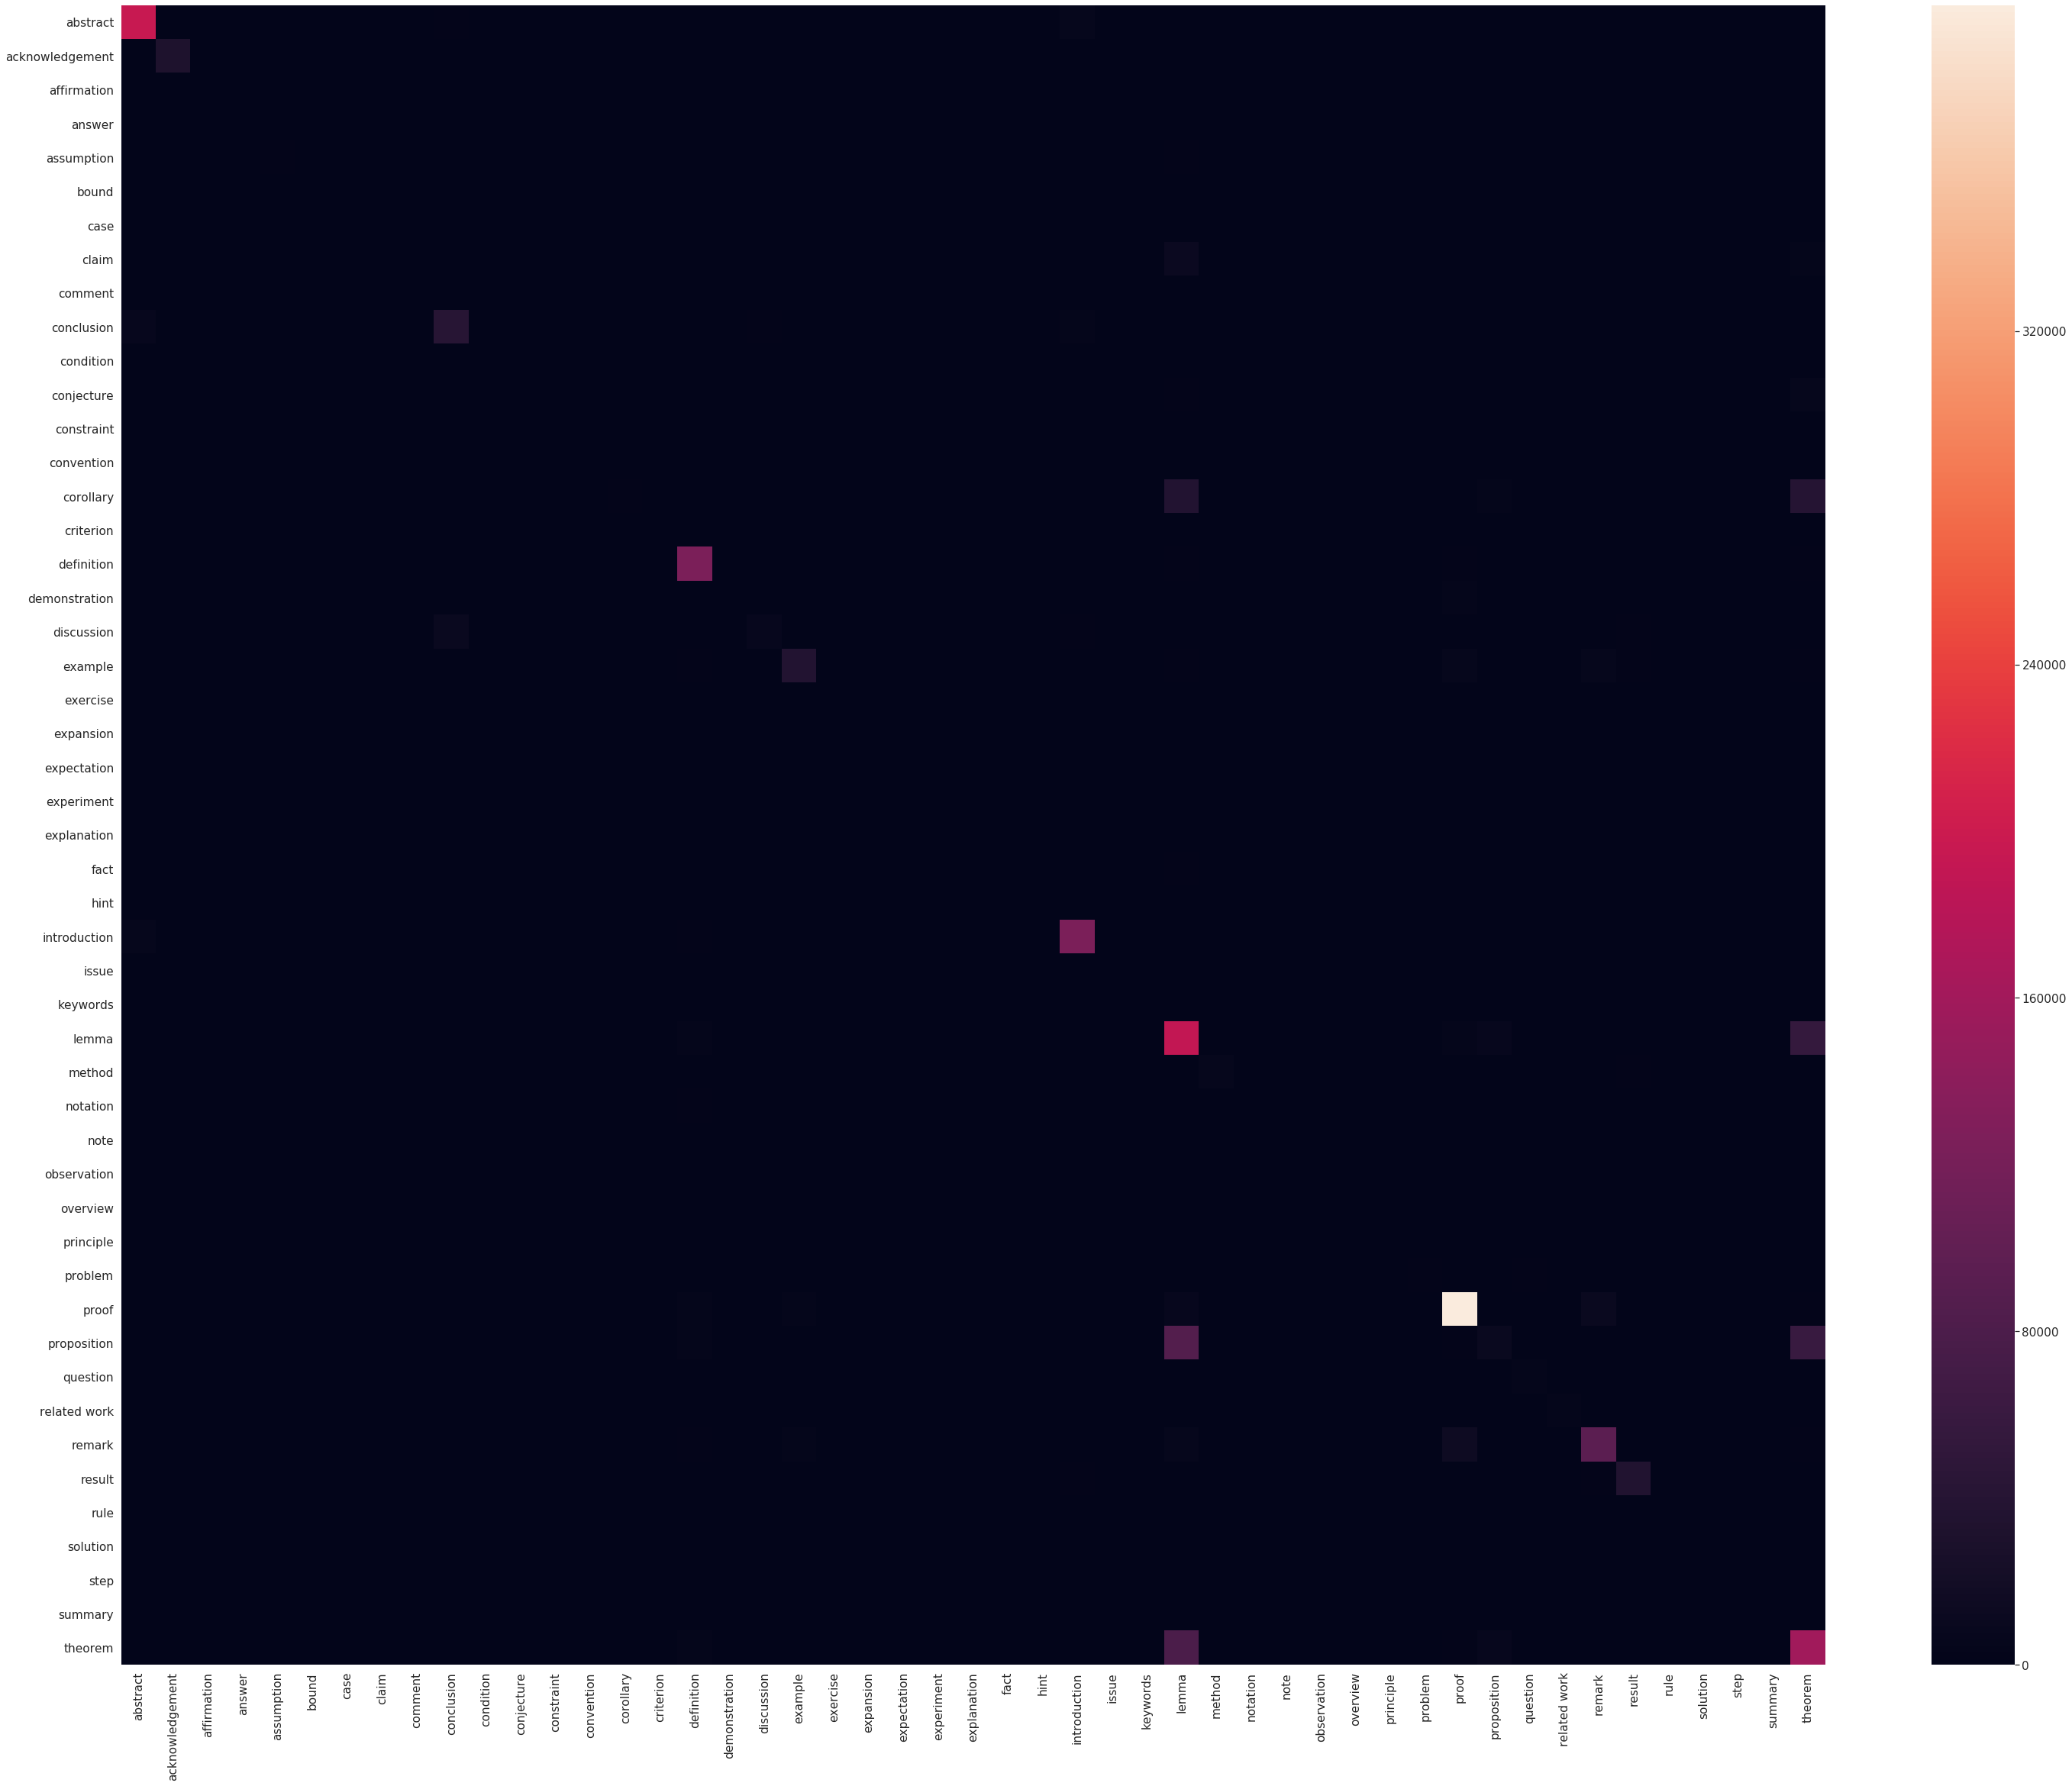

In [15]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


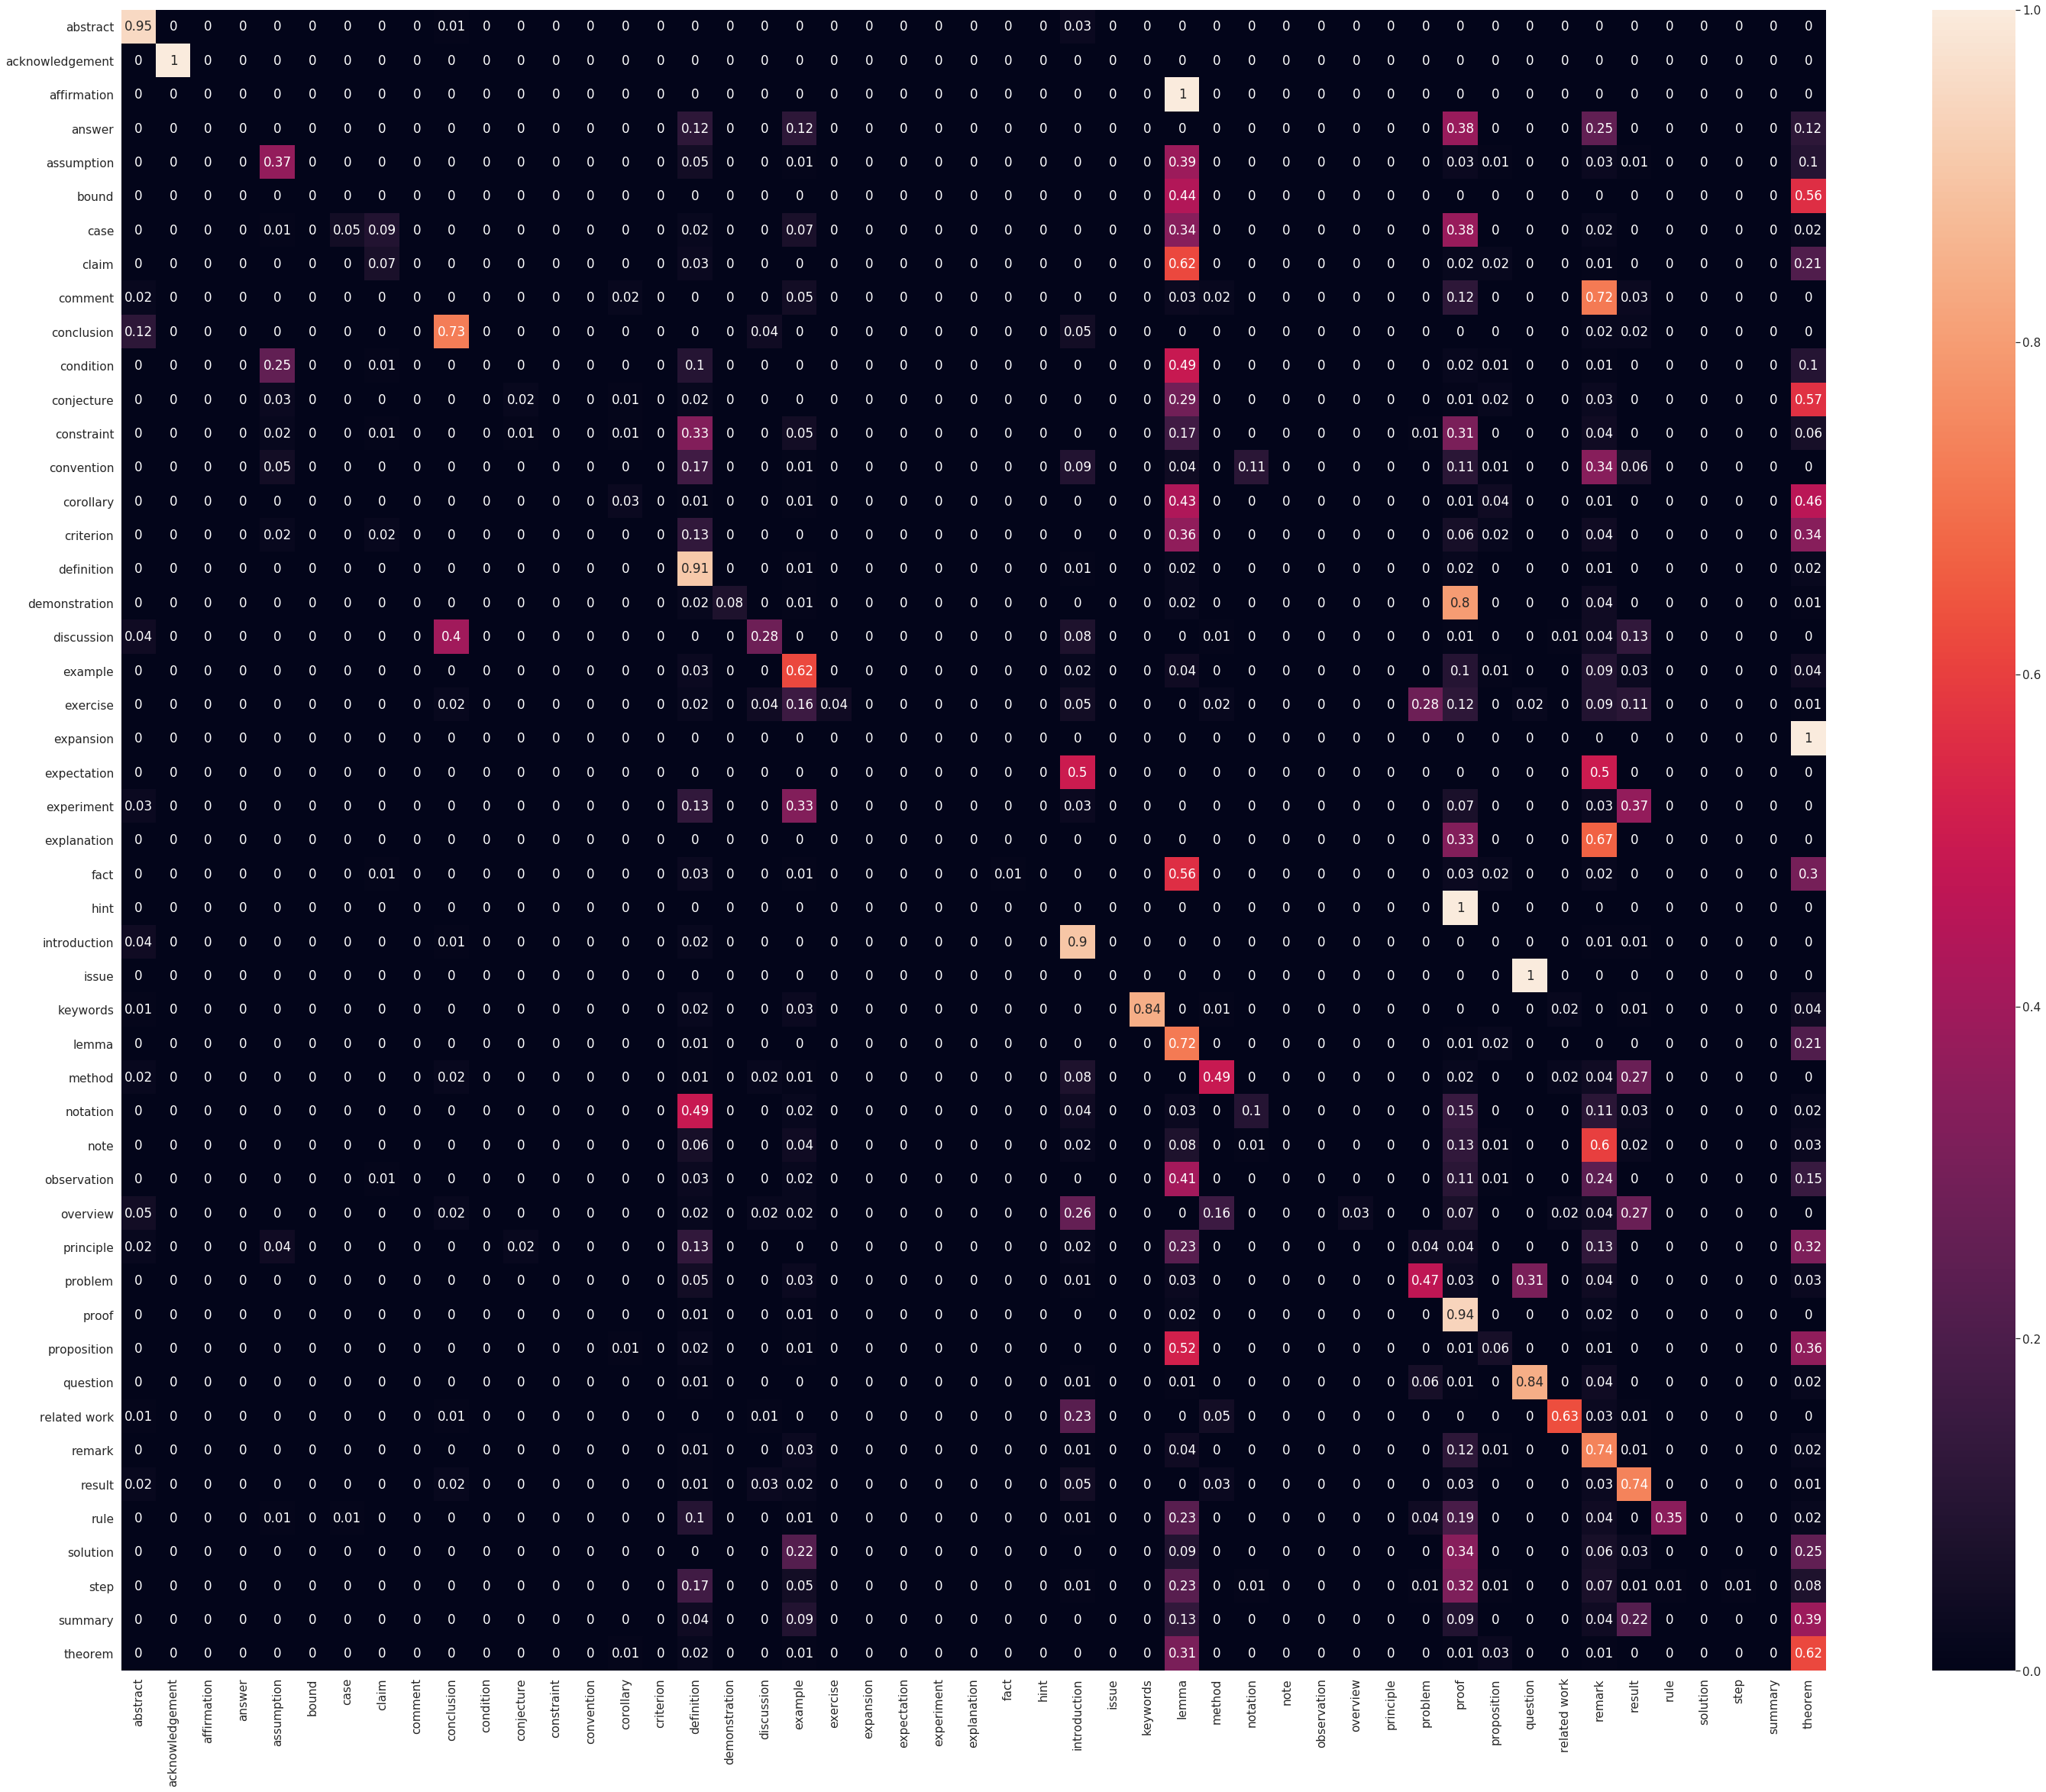

In [16]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Discussion

## Per-class test measures:

Using all 8.4 million paragraphs for training (converged in 14 epochs), then testing on the full 2.1 million:
```
              precision    recall  f1-score   support
           0       0.93      0.95      0.94    206154
           1       0.99      1.00      0.99     32445
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         8
           4       0.50      0.37      0.43      5915
           5       0.00      0.00      0.00         9
           6       0.35      0.05      0.09       651
           7       0.53      0.07      0.12     17947
           8       0.00      0.00      0.00        65
           9       0.74      0.73      0.74     56916
          10       0.00      0.00      0.00       789
          11       0.46      0.02      0.03      8978
          12       0.00      0.00      0.00       150
          13       0.25      0.00      0.00       435
          14       0.40      0.03      0.05     87353
          15       0.00      0.00      0.00        47
          16       0.83      0.91      0.87    137342
          17       0.78      0.08      0.15      4608
          18       0.60      0.28      0.38     23330
          19       0.72      0.62      0.67     59029
          20       1.00      0.04      0.07        80
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00        30
          24       0.00      0.00      0.00         3
          25       0.66      0.01      0.02      3547
          26       0.00      0.00      0.00         1
          27       0.86      0.90      0.88    137706
          28       0.00      0.00      0.00         8
          29       0.73      0.84      0.78       313
          30       0.44      0.72      0.55    264128
          31       0.56      0.49      0.53     10193
          32       0.39      0.10      0.16      3322
          33       0.00      0.00      0.00       892
          35       0.00      0.00      0.00      3755
          36       0.68      0.03      0.06      2255
          37       0.00      0.00      0.00        47
          38       0.74      0.47      0.57      6073
          39       0.90      0.94      0.92    425149
          40       0.33      0.06      0.10    165813
          41       0.67      0.84      0.74      5448
          42       0.76      0.63      0.69      5259
          43       0.75      0.74      0.75    127807
          44       0.73      0.74      0.73     47980
          45       0.79      0.35      0.49       154
          46       0.00      0.00      0.00        32
          47       0.84      0.01      0.02      1382
          48       0.00      0.00      0.00        23
          49       0.47      0.62      0.54    257528

   micro avg       0.70      0.70      0.70   2111109
   macro avg       0.42      0.28      0.29   2111109
weighted avg       0.68      0.70      0.67   2111109
```

## Confusion Matrix Analysis

Strong true signal:
 - acknowledgement - 1.0
 - abstract - 0.95
 - proof - 0.94
 - definition - 0.91
 - introduction - 0.9
 - question - 0.84
 - keywords - 0.84
 - remark - 0.74 (proof 0.12)
 - result - 0.74
 - conclusion - 0.73 (abstract 0.12)

Mid-tier true signal:
 - lemma - 0.72 (theorem 0.21)
 - theorem - 0.62 (lemma 0.31)
 - related work - 0.63 (0.23 introduction)
 - example - 0.62 (0.1 proof + 0.1 remark)
 - method - 0.49 (result 0.27)
 - problem - 0.47 (question 0.31)

Strong confused signal:
 - affirmation -> lemma
 - comment -> 0.72 remark
 - demonstration -> 0.8 proof
 - expansion -> 1.0 theorem
 - expectation -> 0.5 introduction + 0.5 remark
 - explanation -> 0.33 proof + 0.67 remark
 - hint -> 1.0 proof
 - issue -> 1.0 question

Weak Confused signal:
 - answer -> remark + proof + example
 - assumption -> 0.37 self + 0.39 lemma + 0.1 theorem
 - bound -> 0.44 lemma + 0.56 theorem
 - case -> lemma + proof
 - claim -> 0.62 lemma + 0.21 theorem
 - condition -> 0.49 lemma + 0.25 assumption
 - conjecture -> 0.57 theorem + 0.29 lemma
 - constraint -> definition + proof + lemma
 - convention -> remark + definition
 - corollary -> 0.43 lemma + 0.46 theorem
 - criterion -> lemma + theorem
 - discussion -> 0.4 conclusion +0.28 self + 0.13 result + 0.08 introduction
 - exercise -> problem + example + result
 - experiment -> 0.33 example + 0.37 result
 - fact - 0.56 lemma + 0.3 theorem
 - note - 0.6 remark+ 0.13 proof
 - notation -> 0.49 definition + 0.15 proof + 0.11 remark
 - proposition -> 0.52 lemma + 0.36 theorem + 0.06 self
 - rule -> self, lemma, proof, definition
 - observation -> 0.41 lemma + 0.24 remark + 0.15 theorem + 0.11 proof
 - overview -> 0.26 introduction + 0.25 result
 - principle -> theorem + lemma + definition + remark
 - solution -> example, proof, lemma, theorem
 - step -> proof,lemma,definition
 - summary -> 0.39 theorem, 0.22 result

----------------------------------------------------------------------------

I. **Strategy for a "confusion-free" classification scheme**
  - preserve strong true signal classes
    - acknowledgement, abstract, proof, definition, introduction, question, keywords, remark, conclusion, result
  - drop any weak confused signal class based on low volume data (< 0.5% of data for biggest class, ~ 10,000 paragraphs)
    - notice, expansion, hint, expectation, explanation, affirmation, answer, issue, bound, summary, experiment,
    - solution, criterion, principle, comment, exercise, constraint, rule, convention, case,
    - step, overview,
  - for bigger classes, drop if not combinable in a meaningful way:
    - drop: notation, observation, method,
  - merge together related mid-tier true signals WHEN related semantically (theorem, lemma)
  - add to merged classes stronger, or clearly interpretable signals that would become strong true signals when added.
    - BIG "proposition" class is clearly motivated, all constituents misclassify to "theorem+lemma":
      - proposition = lemma + theorem + proposition + assumption + condition + fact + conjecture + claim + corollary
    - Enhanced "remark" = remark + note
    - Enhanced "proof" = proof + demonstration
    - Enhanced "question" = question + problem
    - Enhanced "conclusion" = conclusion + discussion
    
  - "example" is a bit on the fence. Keep, as it has 50,000 entries.
  - "related work" is also on the fence. Keep, as it has 50,000 entries.

  **Final assembly**: 24 of the original classes grouped into 13 strongly separable unions:

| Class           | Additional Members | Frequency |
|:----------------|:-------------------|----------:|
| abstract        | -                  | 1,030,774 |
| acknowledgement | -                  |   162,230 |
| conclusion      | discussion         |   401,235 |
| definition      | -                  |   686,717 |
| example         | -                  |   295,152 |
| introduction    | -                  |   688,530 |
| keywords        | -                  |     1,565 |
| proof           | demonstration      | 2,148,793 |
| proposition     | assumption, claim, | 4,060,029 |
| +               | condition,         |         + |
| +               | conjecture,        |         + |
| +               | corollary, fact,   |         + |
| +               | lemma, theorem     |         + |           
| problem         | question           |    57,609 |
| related work    | -                  |    26,299 |
| remark          | note               |   643,500 |
| result          | -                  |   239,931 |

Frequency reported includes the entire 10.5 million paragraph dataset.

  Dropped (25) =
  notice, expansion, hint, expectation, explanation, affirmation, answer, issue, bound, summary, experiment,
  solution, criterion, principle, comment, exercise, constraint, rule, convention, case, step, overview, notation, observation, method
